In [1]:
import copy

In [2]:
from gym_electric_motor import reward_functions
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt


In [4]:
from drmdp import feats
from drmdp.envs import gem

In [5]:
rf = gem.PositiveEnforcementWeightedSumOfErrors(penalty_gamma=1.0)

In [6]:
env = gem.make("Finite-CC-PMSM-v0", reward_fn="default", max_episode_steps=1000)
env

<TimeLimit<DiscretiseActionWrapper<GemObsAsVectorWrapper<FiniteCurrentControlPermanentMagnetSynchronousMotorEnv<Finite-CC-PMSM-v0>>>>>

In [7]:
def get_sample(size: int):
    starting_states = []
    for _ in range(size):
        obs, _ = env.reset()
        starting_states.append(obs)
    return np.stack(starting_states)

In [8]:
starting_states = get_sample(10_000)

In [9]:
starting_states.shape

(10000, 5)

In [10]:
df_so = pd.DataFrame({str(col): starting_states[:,col] for col in range(starting_states.shape[1]) })

In [11]:
df_so

,0,1,2,3,4
0,0.039842,0.191854,0.0,0.0,0.0
1,0.039842,0.191854,0.0,0.0,0.0
2,0.057450,0.225545,0.0,0.0,0.0
3,0.295009,0.236354,0.0,0.0,0.0
4,0.217450,0.234277,0.0,0.0,0.0
...,...,...,...,...,...
9995,0.098284,0.167490,0.0,0.0,0.0
9996,0.226851,0.183519,0.0,0.0,0.0
9997,0.276037,0.026505,0.0,0.0,0.0
9998,0.194649,0.035630,0.0,0.0,0.0


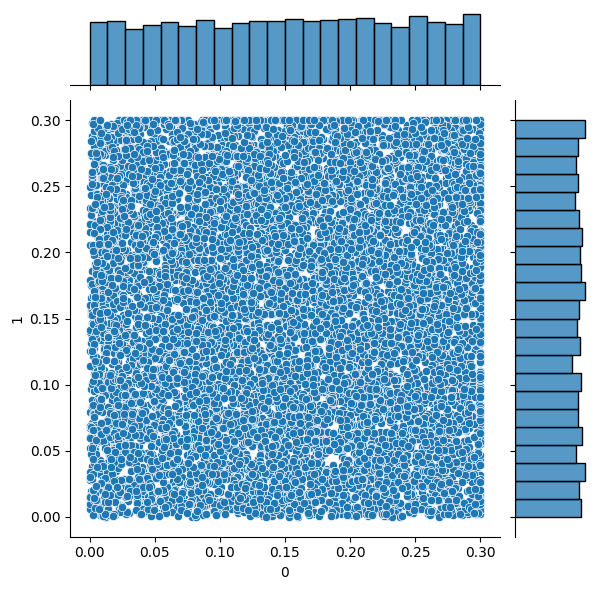

In [12]:
sns.jointplot(data=df_so, x="0", y="1")

In [13]:
env.observation_space.low, env.observation_space.high

(array([ 0.,  0., -1., -1.,  0.]), array([0.8, 0.8, 1. , 1. , 1. ]))

In [14]:
def play(env, num_episodes: int, feat_transform):
    init_obs = []
    returns = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        init_obs.append(obs)
        rewards = 0
        while True:
            action = env.action_space.sample()
            (
                next_obs,
                reward,
                term,
                trunc,
                _,
            ) = env.step(action)
            rewards += reward
            obs = next_obs
            if term or trunc:
                returns.append(rewards)
                break
    return init_obs, returns

In [15]:
def collect_return_sample(env, size: int):
    feat_transform = feats.create_feat_transformer(env, **{"name": "scale", "args": None})
    init_obs, returns = play(env, num_episodes=size, feat_transform=feat_transform)
    return init_obs, returns

In [16]:
collect_return_sample(env, size=10)

([array([0.23696147, 0.15397006, 0.        , 0.        , 0.        ]),
  array([0.15918049, 0.03961326, 0.        , 0.        , 0.        ]),
  array([0.21380696, 0.21163571, 0.        , 0.        , 0.        ]),
  array([0.17310136, 0.08067218, 0.        , 0.        , 0.        ]),
  array([0.21013451, 0.07670277, 0.        , 0.        , 0.        ]),
  array([0.16003338, 0.09515203, 0.        , 0.        , 0.        ]),
  array([0.126555  , 0.23822866, 0.        , 0.        , 0.        ]),
  array([0.06040926, 0.02281795, 0.        , 0.        , 0.        ]),
  array([0.12437828, 0.11641078, 0.        , 0.        , 0.        ]),
  array([0.26207958, 0.16965821, 0.        , 0.        , 0.        ])],
 [-136.05318573227194,
  -164.19869968830804,
  -126.33078896554233,
  -184.34940381681545,
  -248.8087061897543,
  -259.6109775729196,
  -66.40856896377021,
  -158.66149609273654,
  -213.01820267885984,
  -251.2191848836024])

## Reward Patterns

In [17]:
MAX_STEPS = 1000

In [18]:
def collect_reward_sample(reward_fn, size: int):
    env = gem.make("Finite-CC-PMSM-v0", reward_fn=reward_fn, max_episode_steps=MAX_STEPS, constraint_violation_reward=-100)
    obs, _ = env.reset()
    logs = []
    num_steps = 0
    while num_steps < size:
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(
            action
        )
        logs.append((copy.copy(obs), action, copy.copy(next_obs), reward))
        obs = next_obs
        done = term or trunc
        num_steps += 1

        if (num_steps + 1) % (size // 5) == 0:
            print("Step", num_steps + 1)

        if done:
            obs, _ = env.reset()
    env.close()
    return logs

In [19]:
default_rew_logs = collect_reward_sample(reward_fn="default", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [20]:
default_rew_logs[:5]

[(array([0.15791413, 0.15608325, 0.        , 0.        , 0.        ]),
  5,
  array([ 0.15319884,  0.15334911,  0.00943057, -0.00546827,  0.        ]),
  -0.15327397730782122),
 (array([ 0.15319884,  0.15334911,  0.00943057, -0.00546827,  0.        ]),
  6,
  array([ 0.14750404,  0.1631012 ,  0.01890152, -0.00085036,  0.        ]),
  -0.15530261608786125),
 (array([ 0.14750404,  0.1631012 ,  0.01890152, -0.00085036,  0.        ]),
  6,
  array([0.14350117, 0.18073586, 0.0284617 , 0.00374925, 0.        ]),
  -0.16211851793944893),
 (array([0.14350117, 0.18073586, 0.0284617 , 0.00374925, 0.        ]),
  3,
  array([0.15295512, 0.1907006 , 0.00956892, 0.00337113, 0.        ]),
  -0.17182786235921654),
 (array([0.15295512, 0.1907006 , 0.00956892, 0.00337113, 0.        ]),
  3,
  array([ 0.16315457,  0.18932569, -0.00931758,  0.00302803,  0.        ]),
  -0.17624013128196367)]

In [21]:
pos_rew_logs = collect_reward_sample(reward_fn="pos-enf", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [22]:
pos_rew_logs[:5]

[(array([0.07870263, 0.01661926, 0.        , 0.        , 0.        ]),
  6,
  array([0.08344248, 0.01893656, 0.00947971, 0.00463459, 0.        ]),
  1.948810480885736),
 (array([0.08344248, 0.01893656, 0.00947971, 0.00463459, 0.        ]),
  7,
  array([0.06040929, 0.02170131, 0.00951813, 0.00421264, 0.        ]),
  1.9589447010512433),
 (array([0.06040929, 0.02170131, 0.00951813, 0.00421264, 0.        ]),
  0,
  array([0.05915561, 0.01637085, 0.00955243, 0.00379071, 0.        ]),
  1.9622367674085237),
 (array([0.05915561, 0.01637085, 0.00955243, 0.00379071, 0.        ]),
  0,
  array([0.04266523, 0.01853109, 0.0095826 , 0.00336883, 0.        ]),
  1.969401836872424),
 (array([0.04266523, 0.01853109, 0.0095826 , 0.00336883, 0.        ]),
  2,
  array([0.05849816, 0.03001894, 0.00037349, 0.00803732, 0.        ]),
  1.955741450115189)]

In [23]:
highpenalty_rew_logs = collect_reward_sample(reward_fn="esp-neg", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [24]:
highpenalty_rew_logs[:5]

[(array([0.07673793, 0.1407432 , 0.        , 0.        , 0.        ]),
  0,
  array([ 7.67389283e-02,  1.40949438e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  -0.10884418320257333),
 (array([ 7.67389283e-02,  1.40949438e-01, -2.00632955e-06, -4.12468445e-04,
          0.00000000e+00]),
  6,
  array([0.06977492, 0.13882739, 0.00952275, 0.00421339, 0.        ]),
  -0.10430115832963394),
 (array([0.06977492, 0.13882739, 0.00952275, 0.00421339, 0.        ]),
  6,
  array([0.06749586, 0.13627582, 0.01913679, 0.00882088, 0.        ]),
  -0.10188583938623662),
 (array([0.06749586, 0.13627582, 0.01913679, 0.00882088, 0.        ]),
  4,
  array([0.05695808, 0.13650074, 0.03812446, 0.00832811, 0.        ]),
  -0.09672941332931657),
 (array([0.05695808, 0.13650074, 0.03812446, 0.00832811, 0.        ]),
  5,
  array([0.04874322, 0.14044379, 0.04741991, 0.00278876, 0.        ]),
  -0.09459350688372162)]

In [25]:
def logs_as_dataframe(rew_logs, tag):
    obs, actions, next_obs, rewards = zip(*rew_logs)
    df_rw_logs = pd.DataFrame(
        {
            "obs": obs,
            "action": actions,
            "next_obs": next_obs,
            "reward": rewards
        }
    )
    df_rw_logs["fn"] = tag
    return df_rw_logs

In [26]:
df_obs_rew = pd.concat([
    logs_as_dataframe(default_rew_logs, tag="default"),
    logs_as_dataframe(pos_rew_logs, tag="pos-enf"),
    logs_as_dataframe(highpenalty_rew_logs, tag="esp-neg"),
])

In [27]:
df_obs_rew

,obs,action,next_obs,reward,fn
0,"[0.15791412568968327, 0.156083247990753, 0.0, ...",5,"[0.1531988420879192, 0.15334911252772324, 0.00...",-0.153274,default
1,"[0.1531988420879192, 0.15334911252772324, 0.00...",6,"[0.1475040368864443, 0.1631011952892782, 0.018...",-0.155303,default
2,"[0.1475040368864443, 0.1631011952892782, 0.018...",6,"[0.14350117307324145, 0.18073586280565643, 0.0...",-0.162119,default
3,"[0.14350117307324145, 0.18073586280565643, 0.0...",3,"[0.15295512284882046, 0.19070060186961263, 0.0...",-0.171828,default
4,"[0.15295512284882046, 0.19070060186961263, 0.0...",3,"[0.16315457013754686, 0.18932569242638048, -0....",-0.176240,default
...,...,...,...,...,...
9995,"[0.1366847452437384, 0.05457791327111701, -0.0...",1,"[0.14458061188696722, 0.054561963163757186, -0...",-0.099571,esp-neg
9996,"[0.14458061188696722, 0.054561963163757186, -0...",0,"[0.14600934536325627, 0.05736291651051528, -0....",-0.101686,esp-neg
9997,"[0.14600934536325627, 0.05736291651051528, -0....",0,"[0.14411477411932497, 0.05121995235356352, -0....",-0.097667,esp-neg
9998,"[0.14411477411932497, 0.05121995235356352, -0....",6,"[0.13573478270158668, 0.05238703730817332, -0....",-0.094061,esp-neg


## State ~ Reward

In [28]:
def plot_rewards(df, state_idx):
    # remove extremes for pos
    df_plot = copy.deepcopy(df)
    df_plot = df_plot[np.abs(df["reward"].values) < (2**30 - 1)]
    actions = tuple(sorted(df_plot["action"].unique()))
    fig, axes = plt.subplots(ncols=len(actions), figsize=(4*len(actions), 4))
    for action, ax in zip(actions, axes.flatten()):
        df_subplot = df_plot[df_plot["action"] == action]
        df_subplot = copy.deepcopy(df_subplot[["obs", "reward", "fn"]])
        df_subplot["obs"] = df_subplot["obs"].apply(lambda xs: xs[state_idx])
        sns.scatterplot(data=df_subplot, x="obs", y="reward", hue="fn", ax=ax)
        ax.set_title(f"$S[{state_idx}]$, Action: {action}")

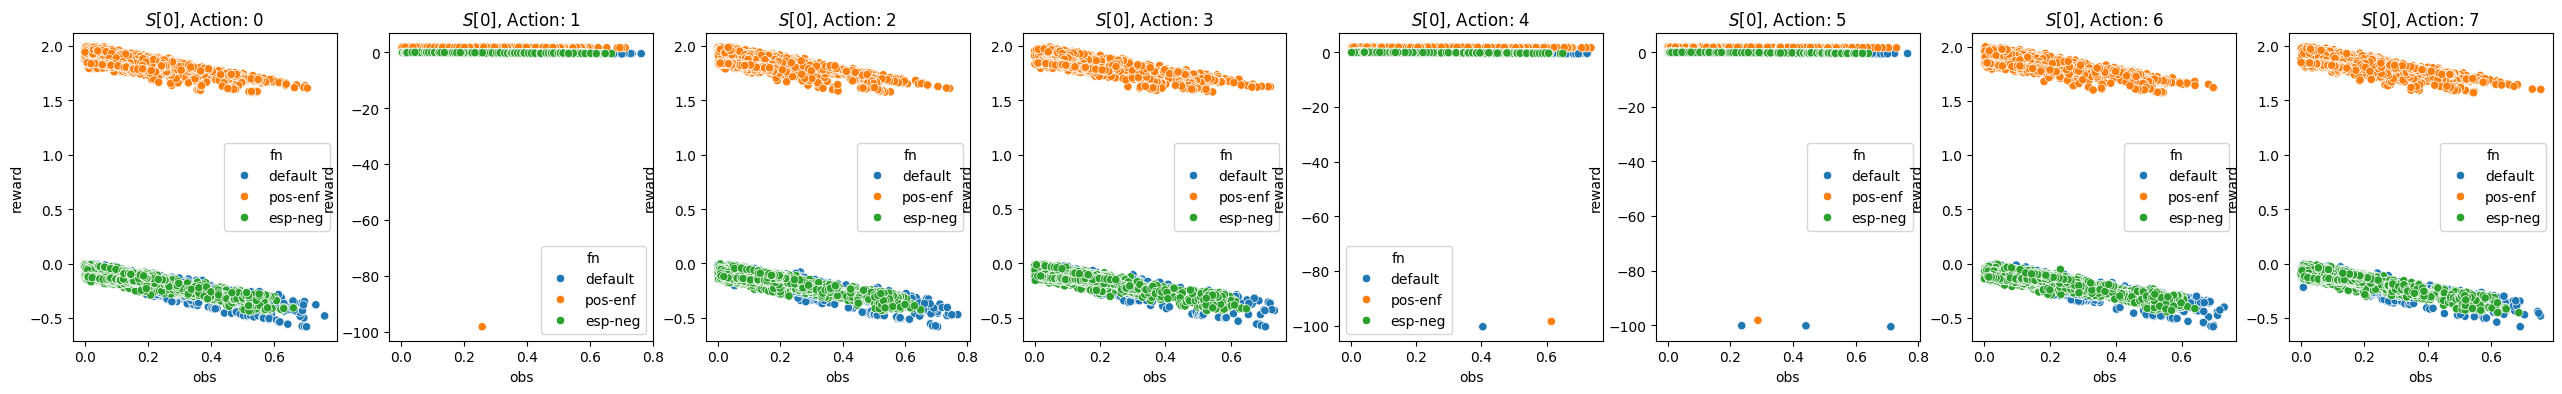

In [29]:
plot_rewards(df_obs_rew, state_idx=0)

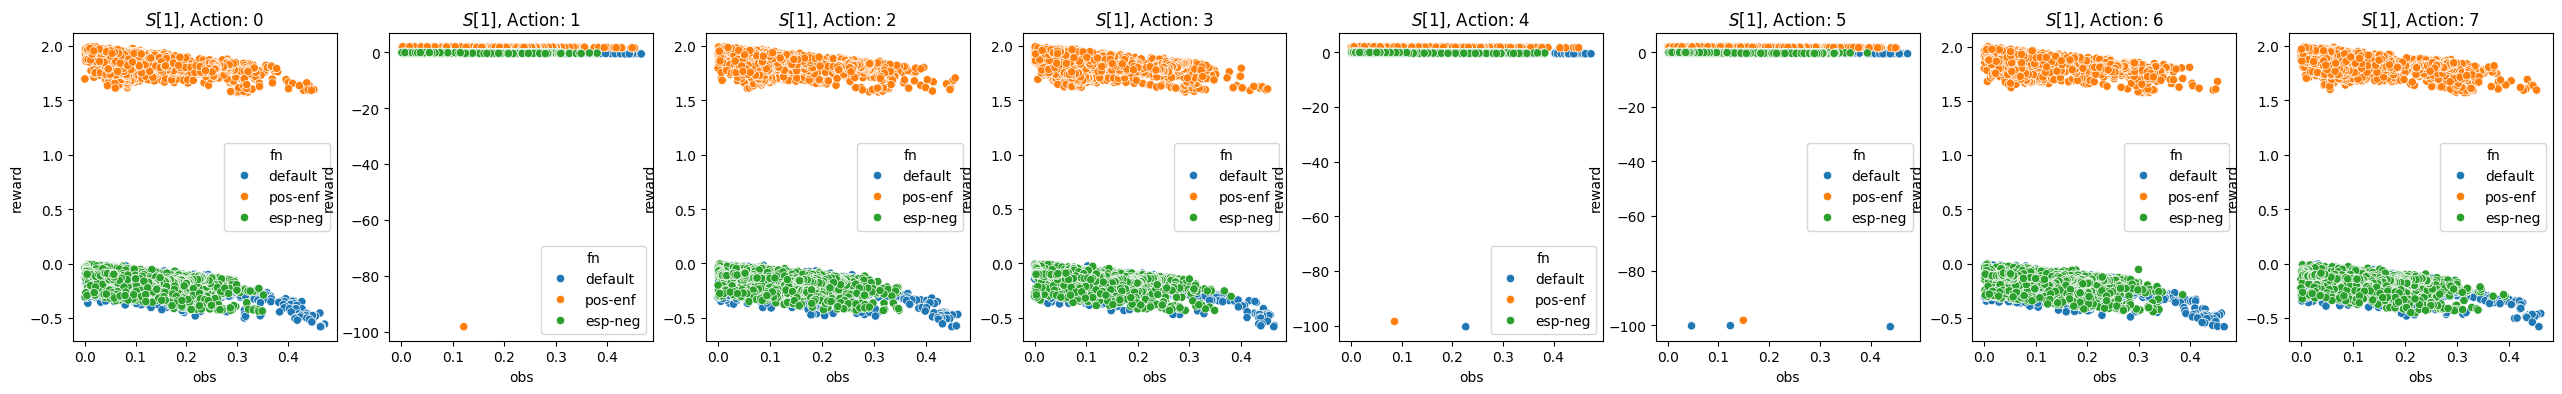

In [30]:
plot_rewards(df_obs_rew, state_idx=1)

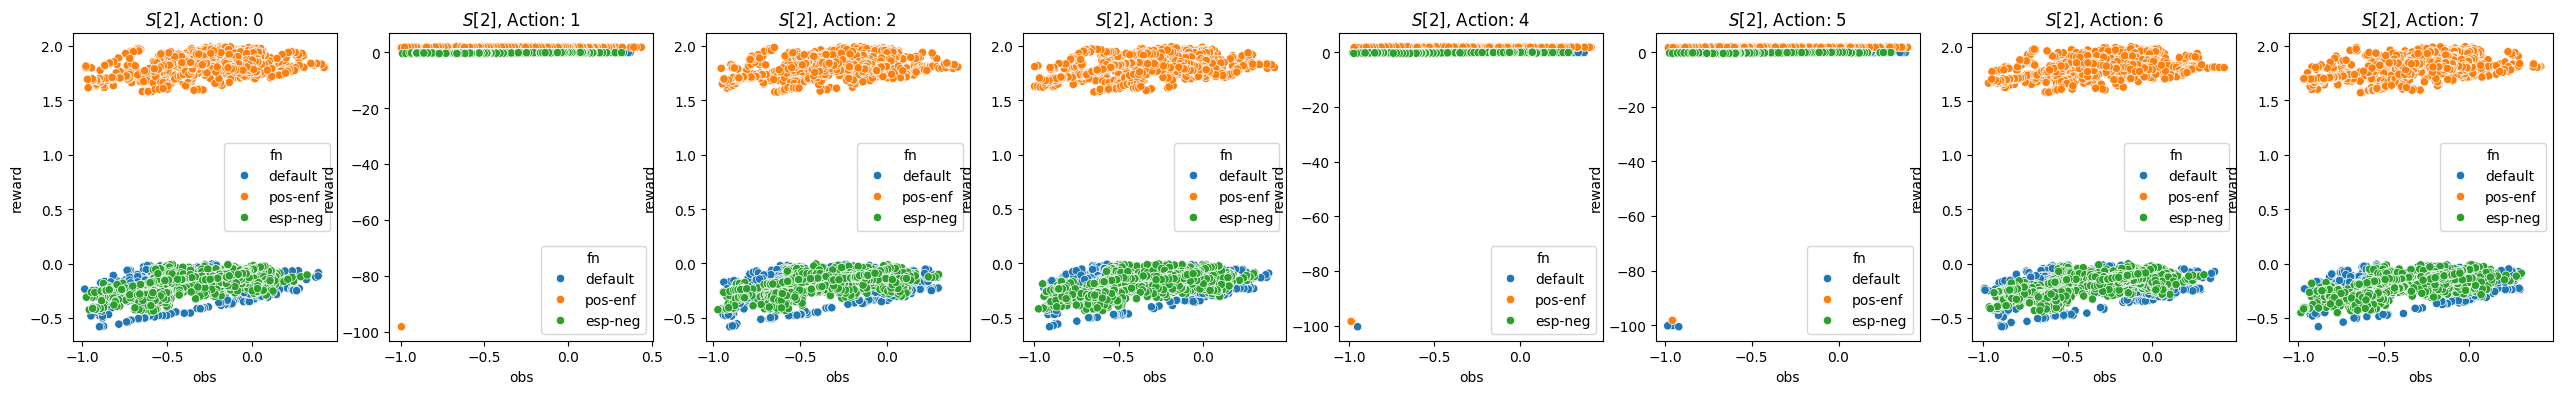

In [31]:
plot_rewards(df_obs_rew, state_idx=2)

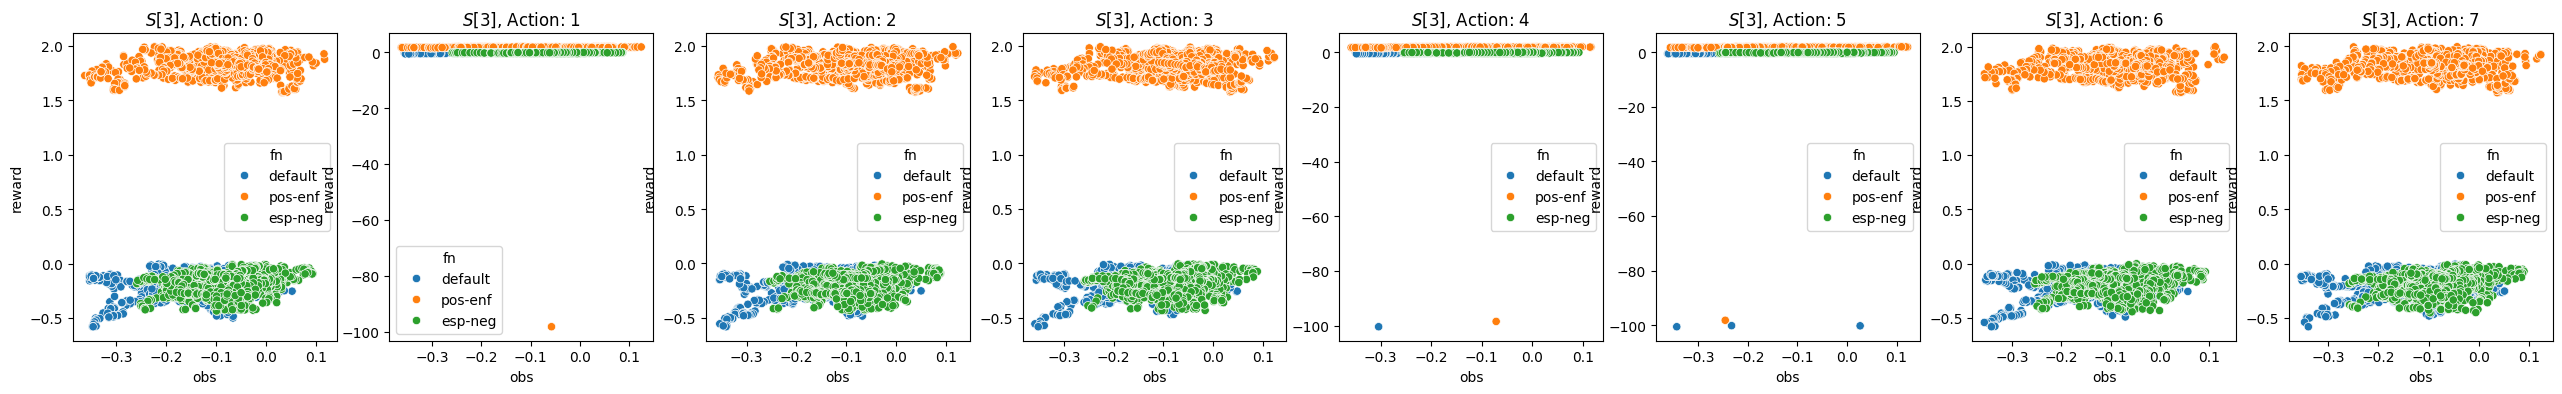

In [32]:
plot_rewards(df_obs_rew, state_idx=3)

## State $\Delta$ ~ Reward

In [33]:
def plot_state_change_rewards(df, state_idx):
    # remove extremes for pos
    df_plot = copy.deepcopy(df)
    df_plot = df_plot[np.abs(df["reward"].values) < (2**30 - 1)]
    actions = tuple(sorted(df_plot["action"].unique()))
    fig, axes = plt.subplots(ncols=len(actions), figsize=(4*len(actions), 4))
    for action, ax in zip(actions, axes.flatten()):
        df_subplot = df_plot[df_plot["action"] == action]
        df_subplot = copy.deepcopy(df_subplot[["obs", "next_obs", "reward", "fn"]])
        obs = df_subplot["obs"].apply(lambda xs: xs[state_idx])
        next_obs = df_subplot["next_obs"].apply(lambda xs: xs[state_idx])
        df_subplot["state_delta"] = next_obs - obs
        sns.scatterplot(data=df_subplot, x="state_delta", y="reward", hue="fn", ax=ax)
        ax.set_title(f"$S[{state_idx}]$, Action: {action}")

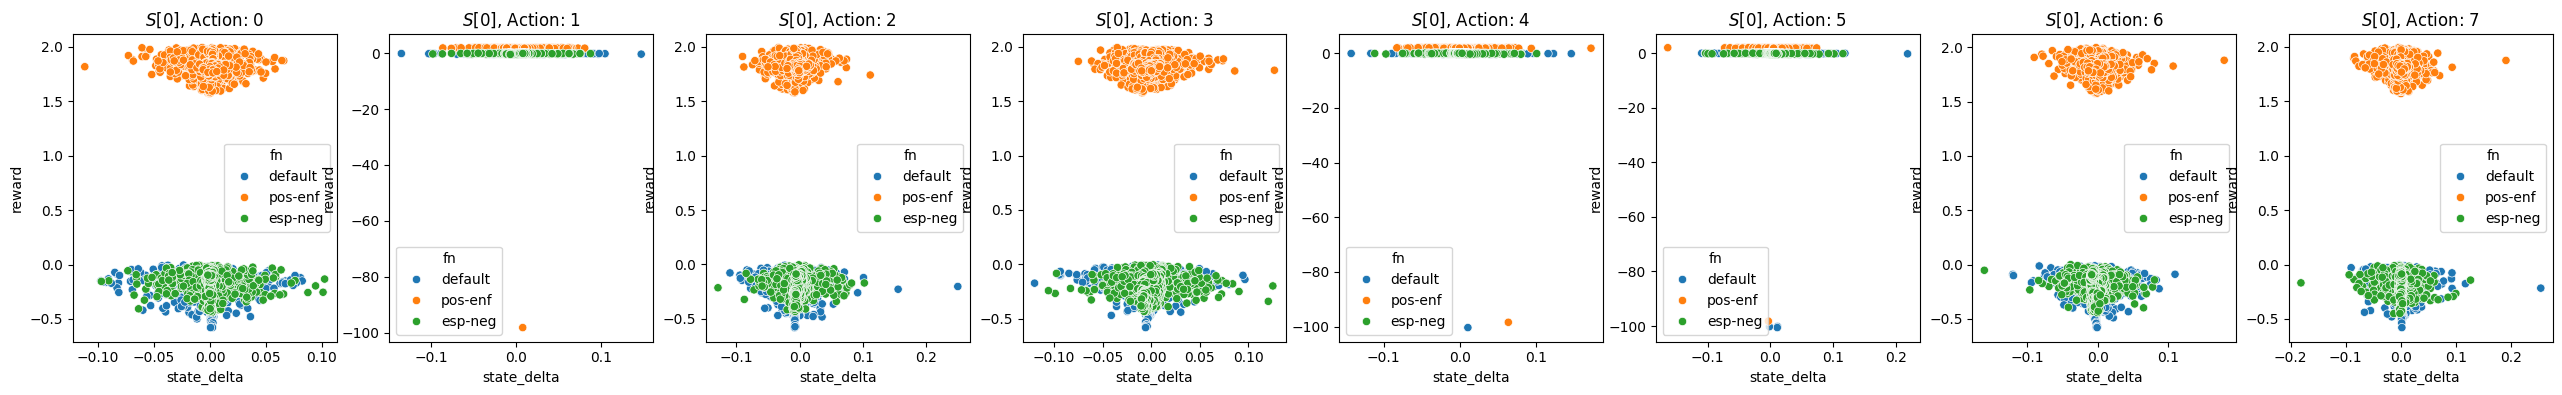

In [34]:
plot_state_change_rewards(df_obs_rew, state_idx=0)

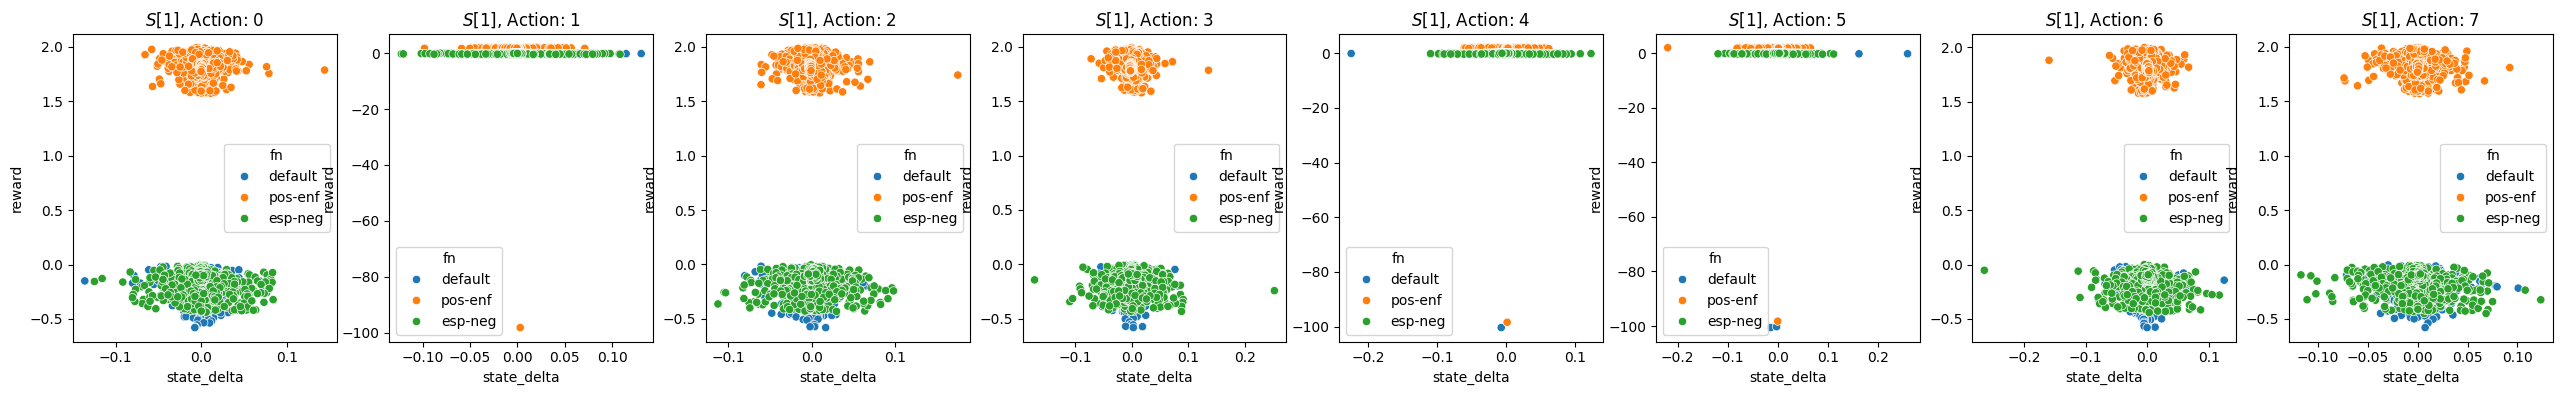

In [35]:
plot_state_change_rewards(df_obs_rew, state_idx=1)

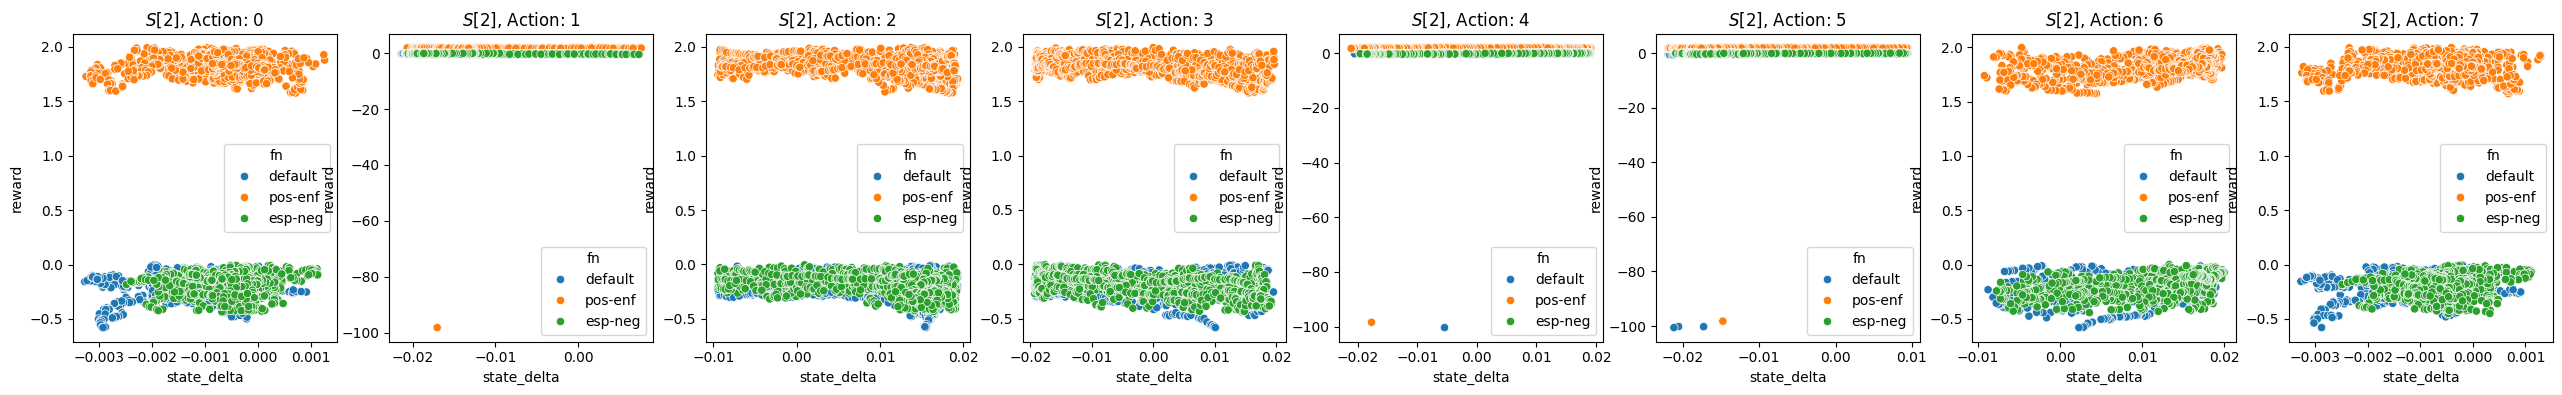

In [36]:
plot_state_change_rewards(df_obs_rew, state_idx=2)

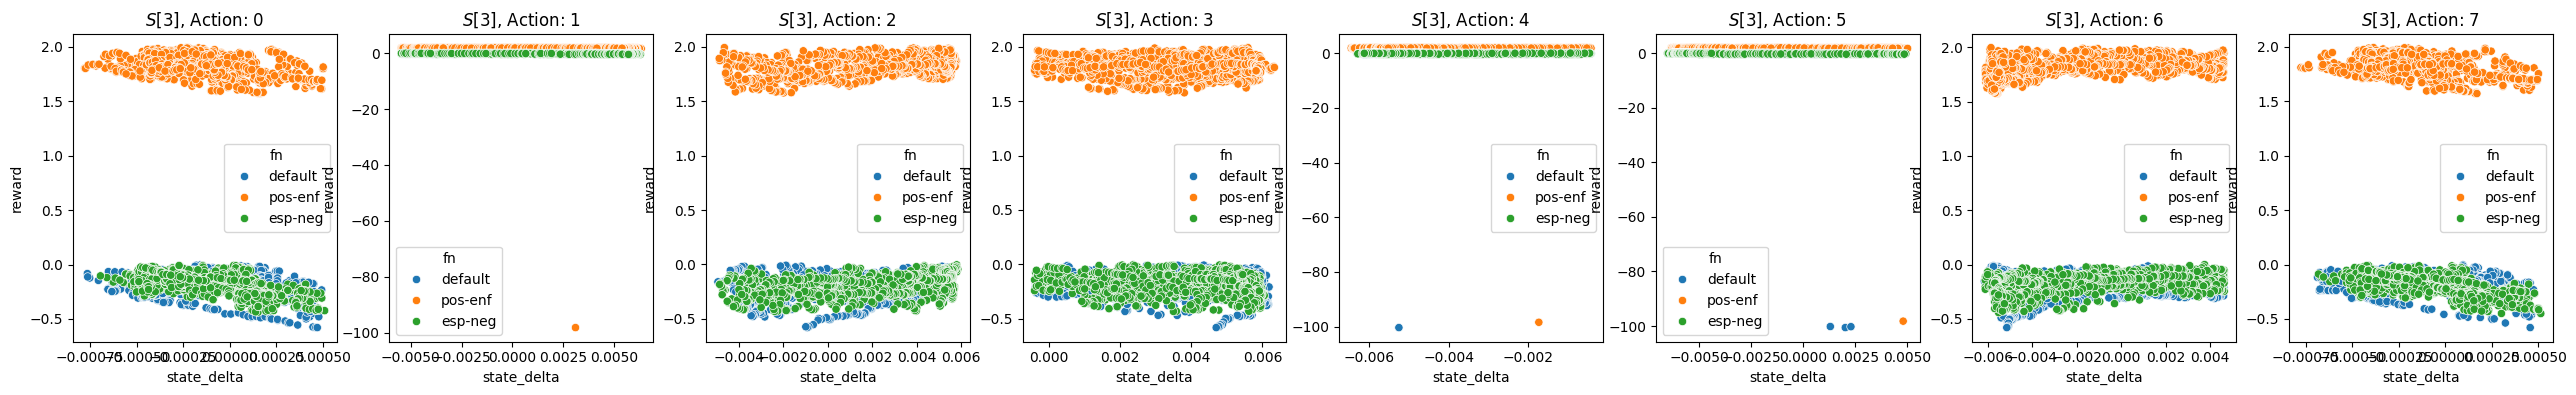

In [37]:
plot_state_change_rewards(df_obs_rew, state_idx=3)